In [ ]:
!pip install fer
! pip install transformers
! pip install pysrt
from fer import Video
from fer import FER
import os
import sys
import pysrt
import pandas as pd
import os
import torch
from transformers import AutoModelForSequenceClassification
from transformers import BertTokenizerFast
import librosa
from matplotlib import pyplot as plt
import librosa.display
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, Model
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.1/812.1 KB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 25.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 59.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.4/104.4 KB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pysrt: filename=pysrt-1.1.2-py3-none-any.whl size=13443 sha256=ed16a44a6db008c698d04bba4fe06f40eb081a04666374f35e9fd77736f92081
  Stored in directory: /root/.cach

# Audio

In [ ]:
! ffmpeg -i "drive/MyDrive/videoplayback (1).mp4" -ab 160k -ac 2 -ar 44100 -vn audio.wav

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/my_model (1)')

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def mler(rms):
    lef=0
    delta=0.06
    lowthresh=rms.mean()*delta
    for val in rms:
        lef+=np.sign(lowthresh-val)+1
    mler=lef/len(rms)
    return mler

def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path, i):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=5, offset=i)
    x = pitch(data, sample_rate)
    
    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [ ]:
path = "/content/audio.wav"
X, Y = [], []
i = 0
pbar = tqdm(total = 2148*5+1)
while True:
    feature = get_features(path,i)
    for ele in feature:
        X.append(ele)
    pbar.update(5)
    i+=5
pbar.close()

 64%|██████▍   | 6895/10741 [18:56<10:23,  6.17it/s]/usr/local/lib/python3.8/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


ValueError: ignored

In [ ]:
features = pd.DataFrame(X)
features.to_csv('/content/drive/MyDrive/features.csv', index=False)

In [ ]:
features = pd.read_csv('/content/drive/MyDrive/features.csv')

In [ ]:
X = features.values

In [ ]:
from pickle import load
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = load(open('/content/drive/MyDrive/encoder (1).pkl', 'rb'))

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.22.2.post1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
pred =new_model.predict(X)
audio_sent = encoder.inverse_transform(pred)


130/130 [==============================] - 1s 4ms/step


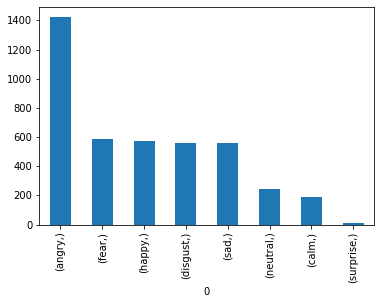

In [ ]:
pd.DataFrame(audio_sent).value_counts().plot(kind='bar')

In [ ]:
from itertools import cycle, islice
df = pd.concat([pd.DataFrame(pred.max(axis=1).reshape(-1,1)),pd.DataFrame(audio_sent.reshape(-1,1))], axis = 1)
my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))

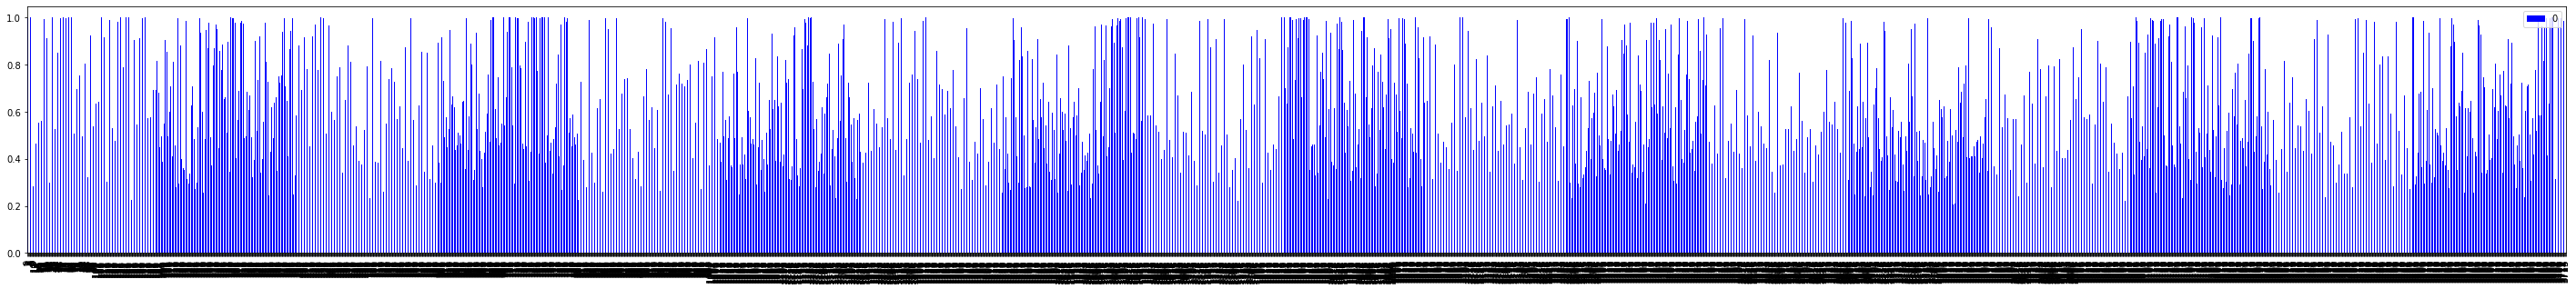

In [ ]:
pd.concat([pd.DataFrame(pred.max(axis=1).reshape(-1,1)),pd.DataFrame(audio_sent.reshape(-1,1))], axis = 1).plot(kind='bar',figsize=(50,5), stacked=True, color = my_colors)

(1, 3717)

In [ ]:
pd.DataFrame({'Sentiment': audio_sent.reshape(1,-1), 'Prob': pred.max(axis=1).reshape(1,-1)})

ValueError: ignored

# Text

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('blanchefort/rubert-base-cased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('blanchefort/rubert-base-cased-sentiment', return_dict=True)


def predict(text):
    inputs = tokenizer(text, max_length=512, padding=True, truncation=True, return_tensors='pt')
    outputs = model(**inputs)
    predicted = torch.nn.functional.softmax(outputs.logits, dim=1)
    predicted = torch.argmax(predicted, dim=1).numpy()
    return predicted

In [ ]:
decode = {'Neutral':0,'Positive':0,'Negative':0}

In [ ]:
subs = pysrt.open('/content/drive/MyDrive/[Russian] Тиньков – болезнь и война _ Tinkov – disease and war [DownSub.com].srt')
total = [0,0,0]
i = 0
pbar = tqdm(total = 2148)
while i < 2184:
  j=i+1
  while (subs[j].end.seconds + subs[j].end.minutes * 60 + subs[j].end.hours * 60**2) - \
  (subs[i].start.seconds + subs[i].start.minutes * 60 + subs[i].start.hours * 60**2) < 4 \
  and j < 2184:
    j+=1
  total[predict(subs[i:j].text)[0]] += 1
  i = j
  pbar.update(1)
pbar.close()


 64%|██████▍   | 6900/10741 [41:19<23:00,  2.78it/s]

 96%|█████████▌| 2066/2148 [03:21<00:07, 10.76it/s]

IndexError: ignored

In [ ]:
decode['Neutral'] = total[0]
decode['Positive'] = total[1]
decode['Negative'] = total[2]

In [ ]:
decode

{'Neutral': 1312, 'Positive': 108, 'Negative': 647}

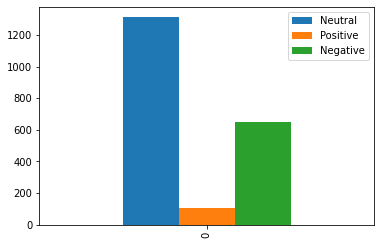

In [ ]:
pd.DataFrame(decode, index=[0]).plot(kind='bar')

# Video

In [ ]:
# Вставить расположение видеофайла, который должен быть обработан
location_videofile = "drive/MyDrive/videoplayback (1).mp4"

# Создайте детектор обнаружения лиц
face_detector = FER(mtcnn=True)
# Введите видео для обработки
input_video = Video(location_videofile)

# Фннкция Analyze() запустит анализ на каждый 100ый кадр входного видео 
# Он создаст прямоугольную рамку вокруг каждого изображения и покажет значения эмоций рядом с ней.
# Наконец, метод опубликует новое видео с рамкой вокруг лица человека с текущими значениями эмоций.
processing_data = input_video.analyze(face_detector, display=False, frequency=100)

# Теперь мы преобразуем проанализированную информацию в фрейм данных.
# Это поможет нам импортировать данные в виде файла .CSV для последующего анализа.
vid_df = input_video.to_pandas(processing_data)
vid_df = input_video.get_first_face(vid_df)
vid_df = input_video.get_emotions(vid_df)

# График эмоций в зависимости от времени в видео
pltfig = vid_df.plot(figsize=(20, 8), fontsize=16).get_figure()

# Теперь мы будем работать с кадром данных, чтобы определить, какая эмоция была заметна в видео.
angry = sum(vid_df.angry)
disgust = sum(vid_df.disgust)
fear = sum(vid_df.fear)
happy = sum(vid_df.happy)
sad = sum(vid_df.sad)
surprise = sum(vid_df.surprise)
neutral = sum(vid_df.neutral)

emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
emotions_values = [angry, disgust, fear, happy, sad, surprise, neutral]

score_comparisons = pd.DataFrame(emotions, columns = ['Human Emotions'])
score_comparisons['Emotion Value from the Video'] = emotions_values
score_comparisons

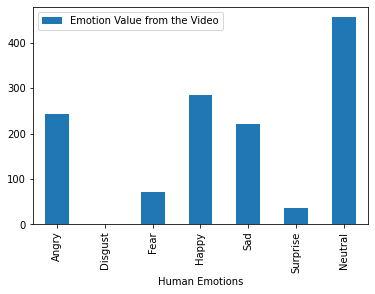

In [ ]:
from numpy.core.shape_base import stack
vid_df = pd.read_csv('/content/video_emotions.csv')
vid_df.drop(columns='Unnamed: 0', inplace = True)
angry = sum(vid_df.angry)
disgust = sum(vid_df.disgust)
fear = sum(vid_df.fear)
happy = sum(vid_df.happy)
sad = sum(vid_df.sad)
surprise = sum(vid_df.surprise)
neutral = sum(vid_df.neutral)

emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
emotions_values = [angry, disgust, fear, happy, sad, surprise, neutral]

score_comparisons = pd.DataFrame(emotions, columns = ['Human Emotions'])
score_comparisons['Emotion Value from the Video'] = emotions_values



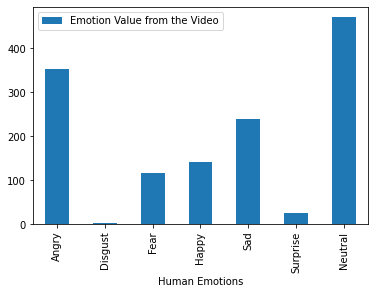

In [ ]:
score_comparisons.index = score_comparisons['Human Emotions']
score_comparisons.plot(kind='bar')

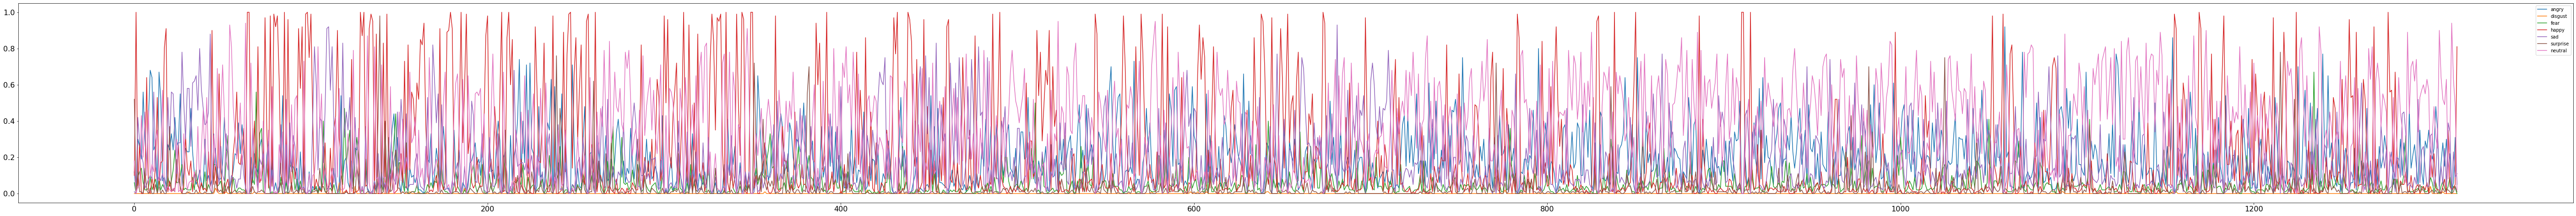

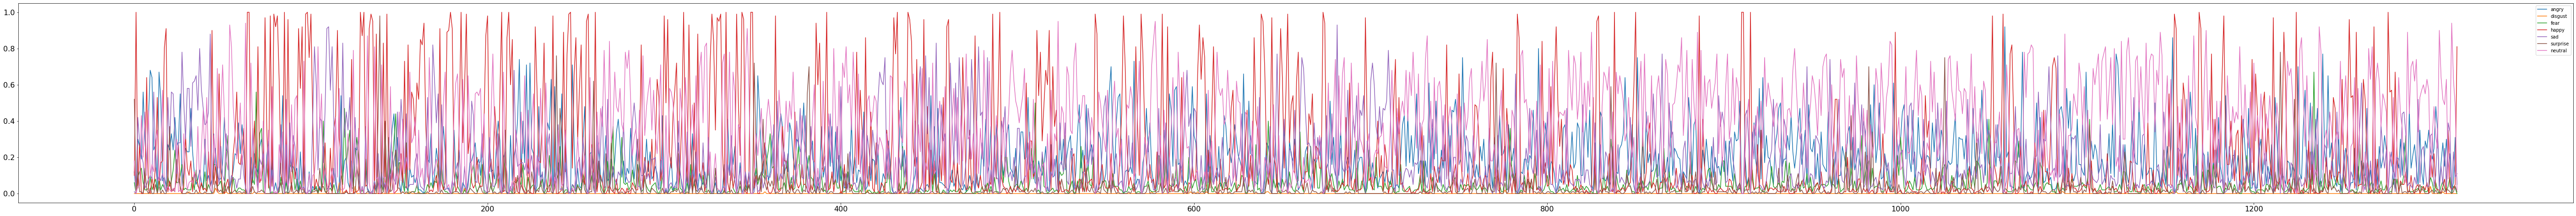

In [ ]:
vid_df.plot(figsize=(100, 8), fontsize=16).get_figure()

In [ ]:
vid_df

angry  disgust  fear  happy   sad  surprise  neutral
0      0.12      0.0  0.06   0.10  0.01      0.52     0.18
1      0.00      0.0  0.00   1.00  0.00      0.00     0.00
2      0.30      0.0  0.09   0.03  0.42      0.12     0.04
3      0.26      0.0  0.12   0.28  0.28      0.01     0.04
4      0.19      0.0  0.14   0.00  0.22      0.01     0.43
...     ...      ...   ...    ...   ...       ...      ...
1311   0.22      0.0  0.09   0.04  0.34      0.01     0.30
1312   0.02      0.0  0.00   0.02  0.01      0.00     0.94
1313   0.06      0.0  0.04   0.03  0.23      0.01     0.63
1314   0.31      0.0  0.03   0.05  0.09      0.04     0.48
1315   0.05      0.0  0.00   0.81  0.11      0.01     0.02

[1316 rows x 7 columns]